# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы.

**Цель работы: построить модель с максимально большим значением accuracy для задачи классификации, которая выберет подходящий тариф**

Описание столбцов
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

### подключение необходходимых для дальнейшей работы библиотек, модулей, метрик

In [1]:
import pandas as pd #Импортируем библиотеку pandas\n",
from sklearn.tree import DecisionTreeClassifier #импортируем модуль Решающее дерево для задачи классификации
from sklearn.ensemble import RandomForestClassifier #импортируем модуль Случайный лес для задачи классификации
from sklearn.linear_model import LogisticRegression #импортируем Логистическую регрессию
from sklearn.model_selection import train_test_split #импортируем train_test_split
from sklearn.metrics import mean_squared_error #импортируем MSE
from sklearn.metrics import accuracy_score #импортируем accuracy
import time #Импортируем модуль time
import matplotlib.pyplot as plt #импортируем библиотеку matplotlib для визуализации гистограмм и графиков

### ознакомление с данными

In [2]:
 #Загрузим данные в df 
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head() #Выведем первые 5 строк df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info() #Посмотрим общую информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


### Вывод по разделу 1

В разделе 1 мы подключили необходходимые для дальнейшей работы библиотеки, модули, метрики и ознакомились с данными

### Разбивка данных на выборки

Разобъём исходные данные на три выборки: обучающая выборка - 60% от всех данных, валидационная выборка - 20% от всех данных, тестовая выборка - 20 % от всех данных)

In [5]:
#признаками будут все столбцы датасета, за исключением is_ultra
features = df.drop('is_ultra', axis=1)
#столбец is_ultra - целевой признак
target = df['is_ultra']
#Разделим датасет в пропорции 60:40
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features,\
target, test_size=0.4, random_state=12345, stratify=target)

In [6]:
#Разделим 40% данных ещё раз в пропорции 50:50
features_test, features_valid, target_test, target_valid = train_test_split(features_valid_test,\
target_valid_test, test_size=0.5, random_state=12345, stratify=target_valid_test)

### Проверка корректности проведенного разделения

In [7]:
print('Размер обучающей выборки (признаки):',features_train.shape[0])
print('Размер обучающей выборки (целевые значения):',target_train.shape[0])
print('Размер валидационной выборки (признаки):',features_valid.shape[0])
print('Размер валидационной выборки (целевые значения):',target_valid.shape[0])
print('Размер тестовой выборки (признаки):',features_test.shape[0])
print('Размер тестовой выборки (целевые значения):',target_test.shape[0])

Размер обучающей выборки (признаки): 1928
Размер обучающей выборки (целевые значения): 1928
Размер валидационной выборки (признаки): 643
Размер валидационной выборки (целевые значения): 643
Размер тестовой выборки (признаки): 643
Размер тестовой выборки (целевые значения): 643


### Вывод по разделу 2

В разделе 2 было проведено разделение исходных данных на три выборки:

1) Обучающая выборка: features_train (признаки), target_train (целевые значения)

2) Валидационная выборка: features_valid (признаки), target_valid (целевые значения)

3) Тестовая выборка: features_test (признаки), target_test (целевые значения)

## Исследуем модели

Для решения задачи классификации используем три модели Решающее дерево, Случайный лес и Логистическую регрессию с различными значениями гиперпараметров. Проведём обучение моделей на обучающей выборке, проверим предсказания на валидационной и тестовой выборке. Определим лучшую модель и набор гиперпараметров, дающий максимальное значение для метрики accuracy

### Модель Дерево решений

In [8]:
#Создадим пустой список. В него вложим результаты предсказания модели с различными значениями гиперпараметров
accuracy_depth=[]
#Лучшее значение accuracy для валидационной выборки
best_accuracy_tree_valid = 0
#Модель с набором гиперпараметров, показавшая лучший результат на валидационной выборке
best_model_tree = None
#Проверим качество модели изменяя максимальную глубину дерева от 1 до 10

for i in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=i) #Создадим пустую модель
    model.fit(features_train, target_train) #Обучим модель на обучающей выборке
    predictions_valid = model.predict(features_valid) #предскажем значение целевых параметров на валидационной выборке
    accuracy_valid = accuracy_score(target_valid, predictions_valid)  #определим accuracy для валидационной выборки
    accuracy_depth.append([i,accuracy_valid]) #дополним список значениями: глубина дерева, accuracy для валидационной и тестовой выборки
    if accuracy_valid > best_accuracy_tree_valid: #определим модель, дающую лучший результат для валидационной выборки
        best_accuracy_tree_valid = accuracy_valid
        best_depth_tree_valid = i
        best_model_tree = model #запишем модель лучшим набором гиперпараметров
        
print('Максимальное Accuracy на валидационной выборке:', best_accuracy_tree_valid, 'Глубина дерева:', best_depth_tree_valid)

Максимальное Accuracy на валидационной выборке: 0.8118195956454122 Глубина дерева: 5


In [9]:
names_column = ['depth', 'accuracy_valid'] #создадим список с названиями колонок для датафрейма
df_accuracy_depth_tree = pd.DataFrame(data=accuracy_depth, columns=names_column).sort_values(by='accuracy_valid', ascending = False)\
.reset_index(drop=True) #создадим датафрейм отсортированный по accuracy

print('ТОП десять для модели Решающее дерево')
display(df_accuracy_depth_tree)

ТОП десять для модели Решающее дерево


,depth,accuracy_valid
0,5,0.811820
1,10,0.802488
2,3,0.799378
3,6,0.799378
4,7,0.797823
5,9,0.794712
6,8,0.783826
7,4,0.774495
8,2,0.768274
9,1,0.729393


Визуализируем полученные для модели данные на графике

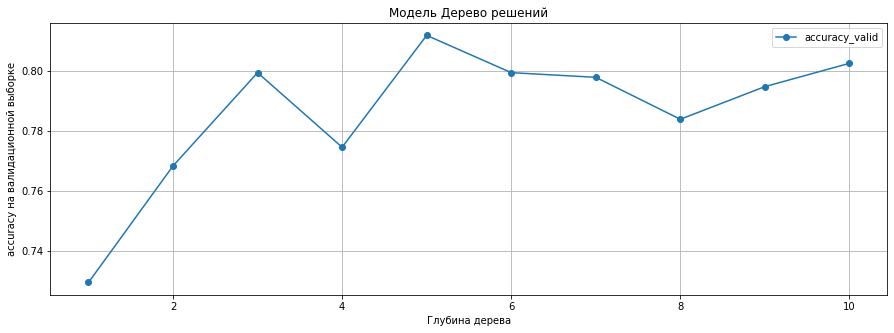

In [10]:
df_accuracy_depth_tree.sort_values(by='depth', ascending = False).plot(x='depth', y='accuracy_valid', \
style='o-', figsize=(15,5), grid = True, title = 'Модель Дерево решений')
plt.xlabel('Глубина дерева')
plt.ylabel('accuracy на валидационной выборке')
plt.show()

### Модель Случайный лес

In [11]:
accuracy_depth_n_estimators=[] #Создадим пустой список. В него вложим результаты предсказания модели с различными значениями гиперпараметров
best_accuracy_forest_valid = 0 #Лучшее значение accuracy для валидационной выборки
best_model_forest = None #Сюда запишем модель с максимальным значением accuracy для валидационной выборки

for j in range(10,101,10): #Проверим качество модели изменяя количество принимающих решение деревьев от 10 до 100 с шагом 10
    for i in range(1, 11): #Проверим качество модели изменяя максимальную глубину дерева от 1 до 10
        model = RandomForestClassifier(random_state=12345, n_estimators=j, max_depth=i) #Создадим пустую модель
        model.fit(features_train, target_train) #Обучим модель на обучающей выборке
        predictions_valid = model.predict(features_valid) #предскажем значение целевых параметров на валидационной выборке
        accuracy_valid = accuracy_score(target_valid, predictions_valid) #определим accuracy для валидационной выборки
        accuracy_depth_n_estimators.append([j,i,accuracy_valid]) #дополним список значениями: глубина дерева, количество деревьев, accuracy для валидационной выборки
        if accuracy_valid > best_accuracy_forest_valid: #определим модель, дающую лучший результат для валидационной выборки
            best_accuracy_forest_valid = accuracy_valid
            best_n_estimators_valid = j
            best_depth_tree_valid = i
            best_model_forest = model

print('Максимальное Accuracy на валидационной выборке:', best_accuracy_forest_valid,\
      'Количество деревьев:', best_n_estimators_valid, 'Глубина дерева:',best_depth_tree_valid)

Максимальное Accuracy на валидационной выборке: 0.8211508553654744 Количество деревьев: 20 Глубина дерева: 6


In [12]:
names_column_forest = ['n_estimators','depth', 'accuracy_valid'] #создадим список с названиями колонок для датафрейма
df_accuracy_depth_forest = pd.DataFrame(data=accuracy_depth_n_estimators, columns=names_column_forest)\
.sort_values(by='accuracy_valid', ascending = False).reset_index(drop=True) #создадим датафрейм отсортированный по accuracy

print('ТОП десять для модели Случайный лес')
display(df_accuracy_depth_forest.head(10))

ТОП десять для модели Случайный лес


,n_estimators,depth,accuracy_valid
0,70,5,0.821151
1,90,6,0.821151
2,20,6,0.821151
3,100,6,0.819596
4,50,5,0.819596
5,80,9,0.819596
6,80,6,0.819596
7,80,5,0.819596
8,40,5,0.818040
9,60,5,0.818040


Визуализируем данные. Лучший результат на валидационной выборке показала модель с 70 независимыми деревьями с глубиной дерева 5. Для этого построим два графика - с фиксированным количеством независимых деревьев - 70 шт и с фиксированной глубиной дерева - 5 

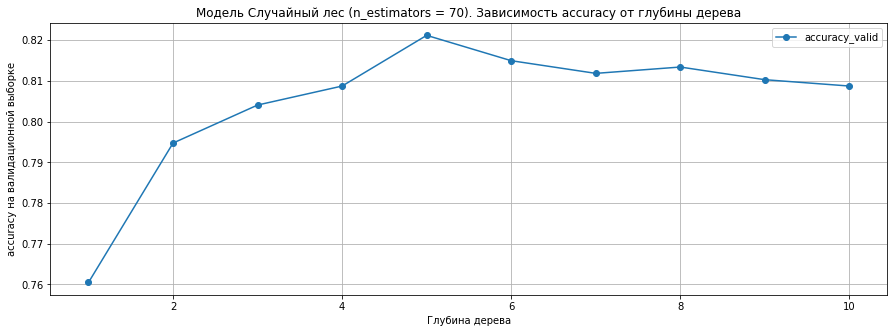

In [13]:
df_accuracy_depth_forest.query('n_estimators == 70').sort_values(by='depth', ascending = False).plot(x='depth', y='accuracy_valid', \
style='o-', figsize=(15,5), grid = True, title = 'Модель Случайный лес (n_estimators = 70). Зависимость accuracy от глубины дерева')
plt.xlabel('Глубина дерева')
plt.ylabel('accuracy на валидационной выборке')
plt.show()

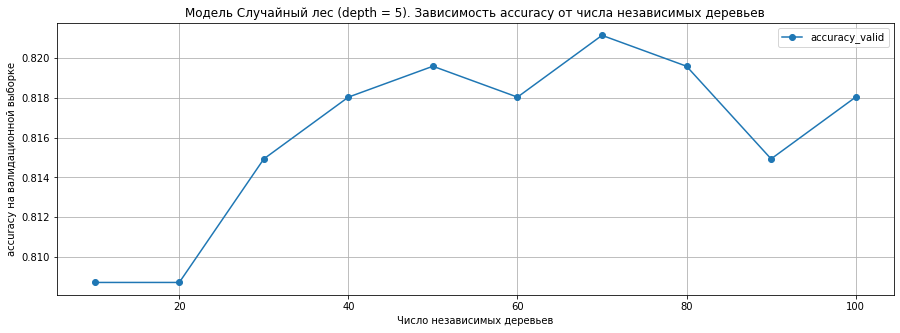

In [14]:
df_accuracy_depth_forest.query('depth == 5').sort_values(by='n_estimators', ascending = False).plot(x='n_estimators', y='accuracy_valid', \
style='o-', figsize=(15,5), grid = True, \
title = 'Модель Случайный лес (depth = 5). Зависимость accuracy от числа независимых деревьев')
plt.xlabel('Число независимых деревьев')
plt.ylabel('accuracy на валидационной выборке')
plt.show()

### Модель Логистическая регрессия

In [15]:
accuracy_max_iter=[] #Создадим пустой список. В него вложим результаты предсказания модели с различными значениями гиперпараметров
best_accuracy_regression_valid = 0  #Лучшее значение accuracy для валидационной выборки
best_model_regression = None #Модель с набором гиперпараметров, показавшая лучший результат на валидационной выборке

for i in range(100,501,50): #Лучшее значение accuracy для тестовой выборки
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=i) 
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy_valid = accuracy_score(target_valid, predictions_valid)
    accuracy_max_iter.append([i,accuracy_valid]) #дополним список значениями: максимальным числом итераций, accuracy для валидационной и тестовой выборки
    if accuracy_valid > best_accuracy_regression_valid:
        best_accuracy_regression_valid = accuracy_valid
        best_max_iter = i
        best_model_regression = model #запишем лучшую модель
        
print('Максимальное Accuracy на валидационной выборке:',best_accuracy_regression_valid, 'Максимальное число итераций:', \
      best_max_iter)

Максимальное Accuracy на валидационной выборке: 0.7465007776049767 Максимальное число итераций: 100


In [16]:
names_column_regression = ['max_iter', 'accuracy_valid'] #создадим список с названиями колонок для датафрейма
df_accuracy_max_iter = pd.DataFrame(data=accuracy_max_iter, columns=names_column_regression)\
.sort_values(by='accuracy_valid', ascending = False).reset_index(drop=True) #создадим датафрейм отсортированный по accuracy для валидационной выборки в порядке убывания
display(df_accuracy_max_iter.head(10))

,max_iter,accuracy_valid
0,100,0.746501
1,150,0.746501
2,200,0.746501
3,250,0.746501
4,300,0.746501
5,350,0.746501
6,400,0.746501
7,450,0.746501
8,500,0.746501


Для гогистической регрессии получили, что результат не зависит от числа итераций (при числе итераций большем или равным 50)

### Вывод по разделу 3

1) Лучший результат на валидационной выборке (accuracy_valid = 0.821151) показала модель Случайный лес с набором гиперпараметров: количество независимых деревьев - 70, глубина дерева - 5

2) Второй результат у модели Дерево решений (accuracy_valid = 0.811820) с глубиной дерева - 5

3) модели Логистическая регрессия не удалось превысит долю правильных ответов 0.75. Модель показала наилучший результат на валидационной выборке accuracy_valid = 0.746501. При этом максимальное число итераций (более 50) не повлияло на результат для данной модели.

## Проверьте модель на тестовой выборке

В разделе три были установлены модели, показавшие лучшее accuracy на валидационной выборке:
    
- Лучшая модель Дерева решений на валидационной выборке записана в best_model_tree

- Лучшая модель Случайный лес на валидационной выборке записана в best_model_forest

- Лучшая модель Логистической регрессии на валидационной выборке записана в best_model_regression

Проверим предсказания моделей на тестовой выборке и время работы выполнения кода для каждой из моделей

### модель Дерево решений на тестовой выборке

In [17]:
start = time.time() #время старт
predictions_tree_test = best_model_tree.predict(features_test) #определим предсказания модели на тестовой выборке
end = time.time() #время стоп
accuracy_test_tree = accuracy_score(target_test, predictions_tree_test) #определим accuracy для тестовой выборки

print('accuracy_valid =',best_accuracy_tree_valid)
print('accuracy_test =',accuracy_test_tree)
print('Затраченное время', round((end - start),4))

accuracy_valid = 0.8118195956454122
accuracy_test = 0.7853810264385692
Затраченное время 0.0024


### модель Случайный лес на тестовой выборке

In [18]:
start = time.time() #время старт
predictions_forest_test = best_model_forest.predict(features_test) #определим предсказания модели на тестовой выборке
end = time.time() #время стоп
accuracy_test_forest = accuracy_score(target_test, predictions_forest_test) #определим accuracy для тестовой выборки

print('accuracy_valid =',best_accuracy_forest_valid)
print('accuracy_test =',accuracy_test_forest)
print('Затраченное время', round((end - start),4))

accuracy_valid = 0.8211508553654744
accuracy_test = 0.8009331259720062
Затраченное время 0.0071


### модель Логистическая регрессия на тестовой выборке

In [19]:
start = time.time() #время старт
predictions_regression_test = best_model_regression.predict(features_test)  #определим предсказания модели на тестовой выборке
end = time.time() #время стоп
accuracy_regression_test = accuracy_score(target_test, predictions_regression_test) #определим accuracy для тестовой выборки

print('accuracy_valid =',best_accuracy_regression_valid)
print('accuracy_test =',accuracy_regression_test)
print('Затраченное время', round((end - start),4))

accuracy_valid = 0.7465007776049767
accuracy_test = 0.7387247278382582
Затраченное время 0.0021


### Вывод по разделу 4

1) Результат модели Дерева решений на тестовой выборке ухудшился, , но находится в пределах минимальной доли правильных ответов 0.75:

   accuracy_valid = 0.8118195956454122
   
   accuracy_test = 0.7853810264385692
   
   Время затраченное на выполнение кода составило 0.0032 сек.
   
2) Результат модели Случайный лес на тестовой выборке также несколько ухудшился, но находится в пределах минимальной доли правильных ответов 0.75:

   accuracy_valid = 0.8211508553654744
   
   accuracy_test = 0.8009331259720062
   
   Время затраченное на выполнение кода составило 0.0075 сек.
   
3) Результат модели Случайный лес на тестовой выборке ухудшился. Предсказания модели на тестовой и валидационной выборке меньше минимальной доли правильных ответов 0.75:

   accuracy_valid = 0.7465007776049767
   
   accuracy_test = 0.7387247278382582
   
   Время затраченное на выполнение кода составило 0.0028 сек.

## Общий вывод

Для целей построения модели для задачи классификации, которая выберет подходящий тариф, было проведено следующее: 

Проведено ознакомление с данными.

Проведено разделение исходных данных на три выборки:
- Обучающая выборка: features_train (признаки), target_train (целевые значения)
- Валидационная выборка: features_valid (признаки), target_valid (целевые значения)
- Тестовая выборка: features_test (признаки), target_test (целевые значения)

Для решения задачи классификации использовались три модели: Решающее дерево, Случайный лес и Логистическая регрессия с различными значениями гиперпараметров. Проведено обучение моделей на обучающей выборке, проверка предсказаний на валидационной и тестовой выборке. Лучшая модель и набор гиперпараметров определялась по значению метрики accuracy

1) Лучший результат на валидационной выборке (accuracy_valid = 0.8211508553654744) показала модель Случайный лес с набором гиперпараметров: количество независимых деревьев - 70, глубина дерева - 5

2) Второй результат у модели Дерево решений (accuracy_valid = 0.8118195956454122) с глубиной дерева - 5

3) модели Логистическая регрессия не удалось превысит долю правильных ответов 0.75. Модель показала наилучший результат на валидационной выборке accuracy_valid = 0.7465007776049767. При этом максимальное число итераций не повлияло на результат для данной модели.

На тестовой выборке получены следующие результаты:

1) Модель Случайный лес, показавшая лучший результат на валидационной выборке (accuracy_valid = 0.8211508553654744) с набором гиперпараметров: количество независимых деревьев - 70, глубина дерева - 5 показала на тестовой выборке результат accuracy_test = 0.8009331259720062. Т.е. качество модели на тестовой выборке ухудшилось, но находится в пределах минимальной доли правильных ответов 0.75

2) Модель Дерево решений с глубиной дерева - 5 показала хороший результат на валидационной выборке accuracy_valid =0.8118195956454122 и на тестовой выборке accuracy_test = 0.7853810264385692

3) Модели Логистическая регрессия не удалось превысит долю правильных ответов 0.75. Модель показала наилучший результат на валидационной выборке accuracy_valid = 0.7465007776049767 и accuracy_test = 0.7387247278382582 на тестовой выборке.

Модель Случайный лес, показавшая лучший результат на валидационной выборке работает, как минимум, в два раза медленнее чем модели Дерево решений и Логистическая регрессия.

Исходя из полученных данных самой лучшей моделью для выбора подходящего тарифа является Модель Случайный лес  с набором гиперпараметров: количество независимых деревьев - 70, глубина дерева - 5. Если принципиальное значение будет иметь скорость обработки данных, то лучшей моделью будет модель Дерево решений с глубиной дерева - 5  

## Проверка модели на адекватность

Определим адекватность моделей сравнивая значения их accuracy с алгоритмом, который предсказывающим постоянный самый распространенный ответ. Найдём каких значений в is_ultra больше 0 или 1:

In [20]:
df_test = df.copy() #используем копию df
print('количество значений 0 в is_ultra =', len(df_test.query('is_ultra == 0')))
print('количество значений 1 в is_ultra =', len(df_test.query('is_ultra == 1')))

количество значений 0 в is_ultra = 2229
количество значений 1 в is_ultra = 985


In [21]:
df_test['0_column'] = df_test['is_ultra']*0 #создадим столбец с нулями

In [22]:
target_test = df_test['is_ultra'] #значения с которыми будем сравнивать предсказания нашей тревиальной модели
predictions_test = df_test['0_column'] #предсказания нашей тревиальной модели

In [23]:
print('accuracy для алгоритма замены предсказаний на 0',accuracy_score(target_test, predictions_test))

accuracy для алгоритма замены предсказаний на 0 0.693528313627878


Таким образом, все три модели показали значение accuracy выше чем у тревиальной модели, которая предсказывает самое распространенное постоянное значение. В данном значении адекватности все три модели: Случайный лес, Дерево решений и Логистическая регрессия являются адекватными